In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 4 # number of sites
J = 1. # Hamiltonian J parameter
mu = 0.5 # Hamiltonian mu parameter

In [5]:
def one_step(omegadt):
    circuit = qiskit.QuantumCircuit(n)
    
    for j in range(n - 1):
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        
        circuit.p(-np.pi / 2., j)
        circuit.p(-np.pi / 2., j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.p(np.pi / 2., j)
        circuit.p(np.pi / 2., j + 1)

        for k in range(j):
            circuit.cx(k, j)
            circuit.rz(J * (n - j - 1) * omegadt, j)
            circuit.cx(k, j)
            
    for j in range(n):
        c = mu
        if j % 2 == 0:
            c *= -1.
        c -= J * ((n - j) // 2)
        circuit.rz(c * omegadt, j)

    return circuit

<ipython-input-6-cb288e7afcf7>:5: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circuit += one_step(omegadt)
/usr/local/lib/python3.8/dist-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


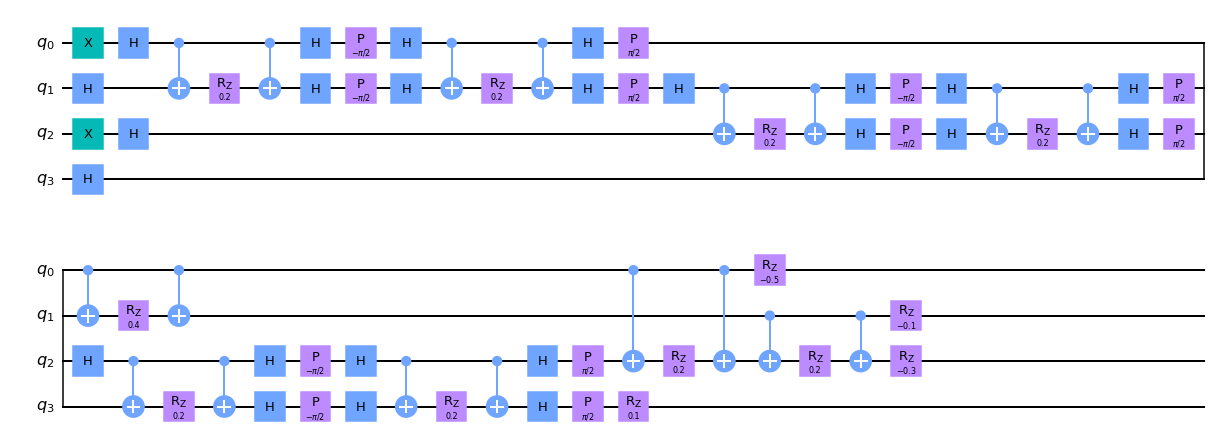

In [6]:
omegadt = 0.2 # Trotter step size

circuit = qiskit.QuantumCircuit(n)
circuit.x(range(0, n, 2))
circuit.compose(one_step(omegadt))

circuit.draw('mpl')

In [8]:
# Define the circuits
circuits = []

circuit = QuantumCircuit(n)

# Initial state = vacuum
circuit.x(range(1, n, 2))

for istep in range(M):
    ##################
    ### EDIT BELOW ###
    ##################



    ##################
    ### EDIT ABOVE ###
    ##################
    
    circuits.append(circuit.measure_all(inplace=False))


def one_step(dt, m=0.5, w=1., J=1., barrier=False):
    qc = qiskit.QuantumCircuit(num_sites)
    
    # exp(-i dt Hzz)
    for iqr in range(1, num_sites - 1):
        phi = J * 0.5 * (2. * dt) * (num_sites - iqr - 1)
        for iql in range(iqr):
            qc.cx(iql, iqr)
            qc.p(phi, iqr)
            qc.cx(iql, iqr)
            
    if barrier:
        qc.barrier()
            
    # exp(-i dt Hpm)
    # Hpm = w sum (sigma+ sigma- + h.c.) = w sum h
    # h = 1/2 XX + 1/2 YY
    phi = w * 0.5 * (2. * dt)
    for iq in range(num_sites - 1):
        # exp(-i dt w/2 XX)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        # exp(-i dt w/2 YY)
        qc.cz(iq, iq + 1)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        qc.cz(iq, iq + 1)
        
    if barrier:
        qc.barrier()

    # exp(-i dt Hz1)
    phi = m * 0.5 * (2. * dt)
    for iq in range(num_sites):
        if iq % 2 == 0:
            qc.u1(-phi, iq)
        else:
            qc.u1(phi, iq)
            
    if barrier:
        qc.barrier()

    # exp(-i dt Hz2)
    for iq in range(num_sites - 1):
        phi = -J * 0.5 * (num_sites // 2 - (iq + 1) // 2) * (2. * dt)
        qc.u1(phi, iq)
            
    if barrier:
        qc.barrier()
            
    return qc

In [6]:
backend = qiskit.Aer.get_backend('statevector_simulator')
def get_density(circuit):
    job = qiskit.execute(circuit, backend)
    statevector = job.result().results[0].data.statevector
    
    indices = np.arange(statevector.shape[0], dtype=np.uint8) # works for only up to 8 qubits
    indices = np.expand_dims(indices, axis=1)
    bitstring = np.unpackbits(indices, axis=1, bitorder='little')[:, :num_sites]
    mask = np.zeros_like(bitstring, dtype=np.bool)
    mask[:, 1::2] = True
    occupied = np.copy(bitstring)
    np.logical_not(bitstring, out=occupied, where=mask)
    occupied = occupied.astype(np.int)
    
    particle_number = np.sum(occupied, axis=1) / num_sites

    return np.sum(np.square(np.abs(statevector)) * particle_number)

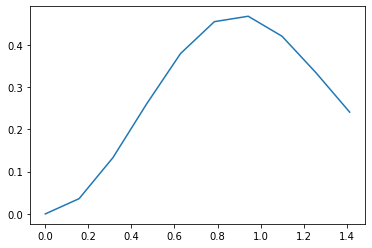

In [9]:
circuit = qiskit.QuantumCircuit(num_sites)
# vacuum
for iq in range(1, num_sites, 2):
    circuit.x(iq)

num_steps = 10
dt = np.pi / 2. / num_steps
density = np.empty(num_steps, dtype=np.float)
for istep in range(num_steps):
    density[istep] = get_density(circuit)
    circuit += one_step(dt)
    
plt.plot(np.arange(0., np.pi / 2, np.pi / 2 / num_steps), density)